### Step 1: Import Libraries
We begin by importing essential libraries required for text processing, visualization, and data handling.

- `re`: For handling regular expressions, which is helpful in text cleaning.
- `nltk`: The Natural Language Toolkit, useful for tokenization, stopword removal, and lemmatization.
- `docx`: To extract text from `.docx` files, typically used for resumes.
- `numpy` and `pandas`: Libraries for data manipulation and handling.
- `seaborn` and `matplotlib.pyplot`: Visualization libraries for data analysis.
- `sklearn.feature_extraction.text.TfidfVectorizer`: For vectorizing text data using TF-IDF.
- `sklearn.metrics.pairwise.cosine_similarity`: To compute the similarity between text documents, useful in matching or recommendation tasks.

In [74]:
import re
import nltk
import docx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


### Step 2: Download Necessary NLTK Data
Here, we download the required NLTK datasets if they are not already available locally.

- `punkt`: Tokenizer models.
- `stopwords`: Commonly used stop words in various languages.
- `wordnet` and `omw-1.4`: Used for lemmatization.


In [56]:
# Download necessary NLTK data (run once)
if not nltk.data.path:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')  


### Step 3: Extract Text from DOCX
Function `extract_text_from_docx` is defined to extract the entire text content from a `.docx` file.

- **Parameters:** Takes in the file path to a `.docx` document.
- **Process:** Reads each paragraph in the document and appends it to a list.
- **Return:** Joins all paragraphs into a single string separated by newlines.

This function is useful for handling resume documents as it transforms the content into a plain text format for processing.


In [57]:
# Extract Text from DOCX 
def extract_text_from_docx(file_path):
    doc = docx.Document(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)

### Step 4: Preprocess the Text
The `preprocess_text` function handles all text preprocessing steps required to clean and prepare the data.

- **Convert to Lowercase:** Ensures uniformity in text by lowering all characters.
- **Remove Non-Alphabetic Characters:** Strips out numbers and special symbols.
- **Tokenization:** Breaks down text into individual words.
- **Stopwords Removal:** Removes common words (like "the", "is", "and") which contribute little to the overall results.
- **Lemmatization:** Reduces words to their base form (e.g., "running" to "run"), improving consistency.

In [58]:
# Preprocess the text
def preprocess_text(text):
    # Convert to string 
    if not isinstance(text, str):
        text = str(text)

    # Convert to lower case
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens - better than stemming as it doesn't produce irregular plurals
    lemmatise = WordNetLemmatizer()
    tokens = [lemmatise.lemmatize(token) for token in tokens]

    # Join the tokens into a single string
    text = ' '.join(tokens)
    return text


### Step 5: Load and Preprocess Resume Data
We load the resume data by specifying the file path and extracting its text content.

- The extracted text is then passed to `preprocess_text` to clean it.
- **Output:** Returns the preprocessed resume text, which is ready for analysis.

In [59]:
# Load resume data 
data_resume = extract_text_from_docx(r"data/resume.docx")
# Preprocess the resumes
resume_processed = preprocess_text(data_resume)



### Step 6: Load and Preprocess the Jobs Data
We load the jobs and their description by specifying the file path and extracting its content.

- The columns of interest are defined. We are primarily interested in the Job Description, Minimum Qualification Requirements and Preferred Skills.
- We loop through the columns and the row in the dataframe and the extracted text is then passed to `preprocess_text` to clean it.
- **Output:** Returns the preprocessed jobs text, which is ready for analysis.

This step completes the data preparation process and is now ready to be Vectorised

In [60]:
# Load the job postings data 
data_jobs = pd.read_csv(r'data/nyc-jobs-1.csv', encoding='utf-8')

# Preprocess job postings
job_columns = ['Job Description', 'Minimum Qual Requirements', 'Preferred Skills']
for column in job_columns:
    data_jobs[f'{column}_processed'] = data_jobs[column].fillna('').apply(preprocess_text)

# Combine the processed columns for job listings
data_jobs['combined_text'] = data_jobs[[f'{col}_processed' for col in job_columns]].apply(lambda x: ' '.join(x), axis=1)


### Step 7: Vectorise the resume and job data using the TF-IDF Vectoriser
We initialise the the vectoriser specifying a max number of features to be 5000. This could be any high number.

- The vectoriser is then fitted onto the preprocessed job and resume text.  
- The combined job text text is converted into a list from a shape of (3420,) to a length of 3420.
- This is done to ensure that both the resume data and Job data are in the same format.

In [61]:
# Initialise and fit TF-IDF vectoriser
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_vectorizer.fit(data_jobs['combined_text'].tolist() + [resume_processed])

# Transform job listings and resume
job_vectors = tfidf_vectorizer.transform(data_jobs['combined_text'])
resume_vector = tfidf_vectorizer.transform([resume_processed])

### Step 8: Cosine similarity 
We use the `cosine_similarity` function to the calculate the similarity between the two vectors.

- The similarity scores are added on to the dataframe as well 
- Finally the similarity score between the data in the resume and the job sheet is sorted in descending order.  
- This will allow us to display the top 10 job title most suitable to the person

In [62]:
# Calculate the cosine similarity between the two vectors
similarity_scores = cosine_similarity(resume_vector, job_vectors)

# Add similarity scores to the dataframe
data_jobs['similarity_score'] = similarity_scores[0]

# Sort jobs by similarity score
df_sorted = data_jobs.sort_values('similarity_score', ascending=False)

In [63]:
# Display top 10 matching jobs
print("Top 10 Matching Jobs:")
for i, row in df_sorted.head(10).iterrows():
    print(f"Job Title: {row['Business Title']}, Similarity Score: {row['similarity_score']:.4f}")

Top 10 Matching Jobs:
Job Title: Database Administrator, Similarity Score: 0.4344
Job Title: Database Administrator, Similarity Score: 0.4344
Job Title: Database Administrator/Developer, Similarity Score: 0.4082
Job Title: Database Administrator/Developer, Similarity Score: 0.4082
Job Title: Computer Systems Manager (M-I), Similarity Score: 0.3702
Job Title: Computer Systems Manager (M-I), Similarity Score: 0.3702
Job Title: SQL/Oracle Database Administrator, Similarity Score: 0.3568
Job Title: SQL/Oracle Database Administrator, Similarity Score: 0.3568
Job Title: SQL/Oracle Database Administrator, Similarity Score: 0.3568
Job Title: SQL/Oracle Database Administrator, Similarity Score: 0.3568


### Step 9: Evaluation
There are several methods to evaluate the performance of a job matching system without labelled data.

##### 1. Cross-Validation
- We can split the job description into training and test sets, vectorise them using TF-IDF and calculate the cosine similairty between the resume and both sets. This will help assess how well the matching generalises to unseen data.
- **Results:** The average cosine similarity between the resume and job description is low for both training and test set. The similarity is slightly higher in the test set, which is good as it shows the model generalises well. But the low similarity suggests the resume might not match the job description that well. 

##### 2. Clustering Analysis
- We can use K-means clustring to group similar job descriptions. It then calculates the average similarity score for each cluster, helping identify which types of jobs the resume matches best with. 
- **Results:** As can be seen the resume has higher similarity with the cluster water management and environmental services and the Business support and data-related roles (13.19%). This is very crucial for us to know as we can tell that this resume is well suited for this type of role.

##### 3. Keyword Overlap Analysis 
- We can calculate the overalp of words between the resume and each job description. It provides a simple measure of content similarity.
- **Results:** We can see that on average about 51 words from the resume appear in each job description. The job with the highest overlap shares 128 words with the resume. This suggests a moderate level of keyword matching.

##### 4. Feature Importance Analysis
- This is the most important evaluation, as it gives us an understanding which features are driving the matching process. 
- **Results:** We can see that the most important terms in the resume according to the TF-IDF scores emphasise SQL, PL, Oracle databases and scripting skills. WIth the highest feature being the need for the SQL skill (48.8%).

##### Overall Results
Overall the resume has low to moderate similairty with most job descriptions. The resume is more suited to Business support and data-related roles, with the key skills required being the database and scripting skills. While there might be some keyword overlap, it is not as high as desired for many jobs. 





In [76]:
# Cross-validation
X_train, X_test = train_test_split(data_jobs['combined_text'], test_size=0.2, random_state=42)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
resume_vector = tfidf_vectorizer.transform([resume_processed])

train_similarities = cosine_similarity(resume_vector, X_train_tfidf)
test_similarities = cosine_similarity(resume_vector, X_test_tfidf)
print("CROSS-VALIDATION RESULT: ")
print(f"Average similarity on training set: {np.mean(train_similarities):.4f}")
print(f"Average similarity on test set: {np.mean(test_similarities):.4f}")
print("------------------------------------------")

# Clustering analysis
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(texts, n=10):
    vectorizer = CountVectorizer(stop_words='english')
    word_count = vectorizer.fit_transform(texts)
    words = vectorizer.get_feature_names_out()
    word_freq = word_count.sum(axis=0).A1
    return [words[i] for i in word_freq.argsort()[-n:][::-1]]

cluster_labels = {}
for cluster in range(5):
    cluster_jobs = data_jobs[data_jobs['cluster'] == cluster]
    
    # Combine job titles and descriptions
    cluster_texts = cluster_jobs['Business Title'] + ' ' + cluster_jobs['Job Description']
    
    top_words = get_top_words(cluster_texts)
    
    # Assign a label based on top words
    label = f"Cluster {cluster}: {', '.join(top_words[:3])}"
    cluster_labels[cluster] = label

print("CLUSTERING ANALYSIS RESULT: ")
for cluster, label in cluster_labels.items():
    cluster_similarities = similarity_scores[0][data_jobs['cluster'] == cluster]
    print(f"{label}")
    print(f"Average similarity: {np.mean(cluster_similarities):.4f}")
print("------------------------------------------")

# Keyword overlap analysis
resume_words = set(resume_processed.split())
data_jobs['keyword_overlap'] = data_jobs['combined_text'].apply(lambda x: len(resume_words.intersection(set(x.split()))))

print("KEYWORD OVERLAP RESULT: ")
print(f"Average keyword overlap: {data_jobs['keyword_overlap'].mean():.2f}")
print(f"Max keyword overlap: {data_jobs['keyword_overlap'].max()}")
print("------------------------------------------")

# Feature Importance analysis
feature_names = tfidf_vectorizer.get_feature_names_out()
top_features = sorted(zip(feature_names, resume_vector.toarray()[0]), key=lambda x: x[1], reverse=True)[:20]
print("FEATURE IMPORTANCE RESULT: ")
print("Top 20 features in resume:")
for feature, score in top_features:
    print(f"{feature}: {score:.4f}")
print("------------------------------------------")

CROSS-VALIDATION RESULT: 
Average similarity on training set: 0.0480
Average similarity on test set: 0.0496
------------------------------------------
CLUSTERING ANALYSIS RESULT: 
Cluster 0: city, new, work
Average similarity: 0.0325
Cluster 1: health, care, bureau
Average similarity: 0.0360
Cluster 2: water, wastewater, new
Average similarity: 0.0418
Cluster 3: support, data, business
Average similarity: 0.1319
Cluster 4: city, new, program
Average similarity: 0.0429
------------------------------------------
KEYWORD OVERLAP RESULT: 
Average keyword overlap: 50.97
Max keyword overlap: 128
------------------------------------------
FEATURE IMPORTANCE RESULT: 
Top 20 features in resume:
sql: 0.4880
pl: 0.3696
oracle: 0.2821
table: 0.2809
script: 0.2062
created: 0.1853
trigger: 0.1528
index: 0.1434
data: 0.1430
database: 0.1334
like: 0.1243
unix: 0.1133
view: 0.1128
bulk: 0.1103
shell: 0.1099
developer: 0.1095
using: 0.1058
worked: 0.1008
package: 0.0945
stored: 0.0880
------------------

### Step 9: Data Visualization of Evaluation

This section presents visualizations to help interpret the evaluation metrics of the job matching prototype.

##### 1. Cross-Validation Visualization
- **Bar Chart**: Displays the average similarity scores for the training and test datasets.
- **Purpose**: To compare how well the resume matches job descriptions in both datasets.

##### 2.Clustering Analysis Visualization
- **Bar Chart**: Shows average similarity scores for each cluster of job descriptions.
- **Purpose**:: To identify which clusters (groups of similar jobs) have higher alignment with the resume.

##### 3.Keyword Overlap Visualization
- **Histogram**: Illustrates the distribution of keyword overlaps between the resume and job descriptions.
- **Purpose**: To assess how many keywords from the resume are present in job descriptions.

##### 4.Feature Importance Visualization
-**Horizontal Bar Chart**: Displays the top 20 features (words) in the resume based on TF-IDF scores.
-**Purpose**: To highlight which words are most influential in defining the resume's content.

These visualizations provide a comprehensive view of how well the resume aligns with various job descriptions, helping to identify strengths and area for improvement in the matching process. 


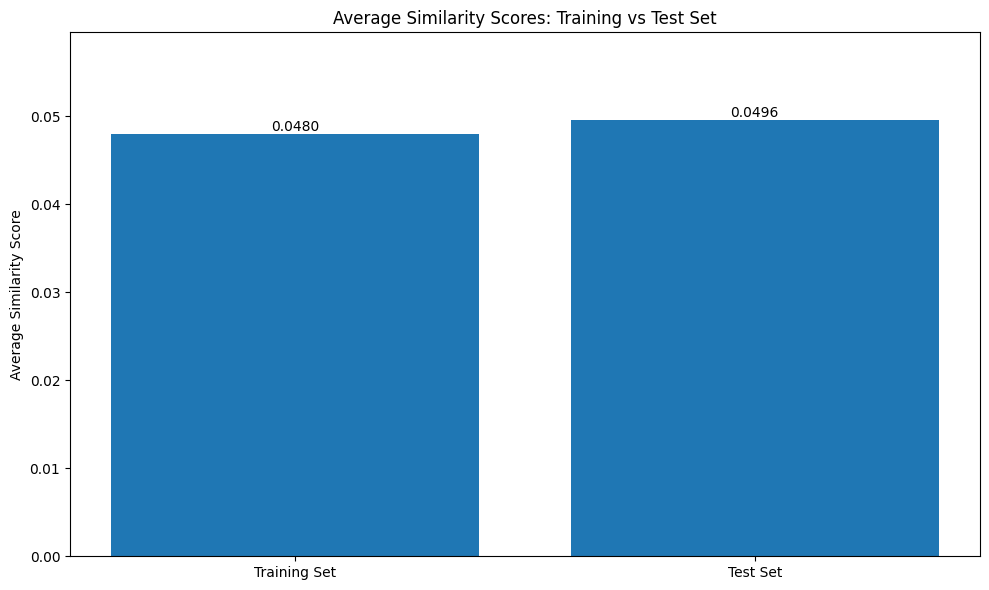

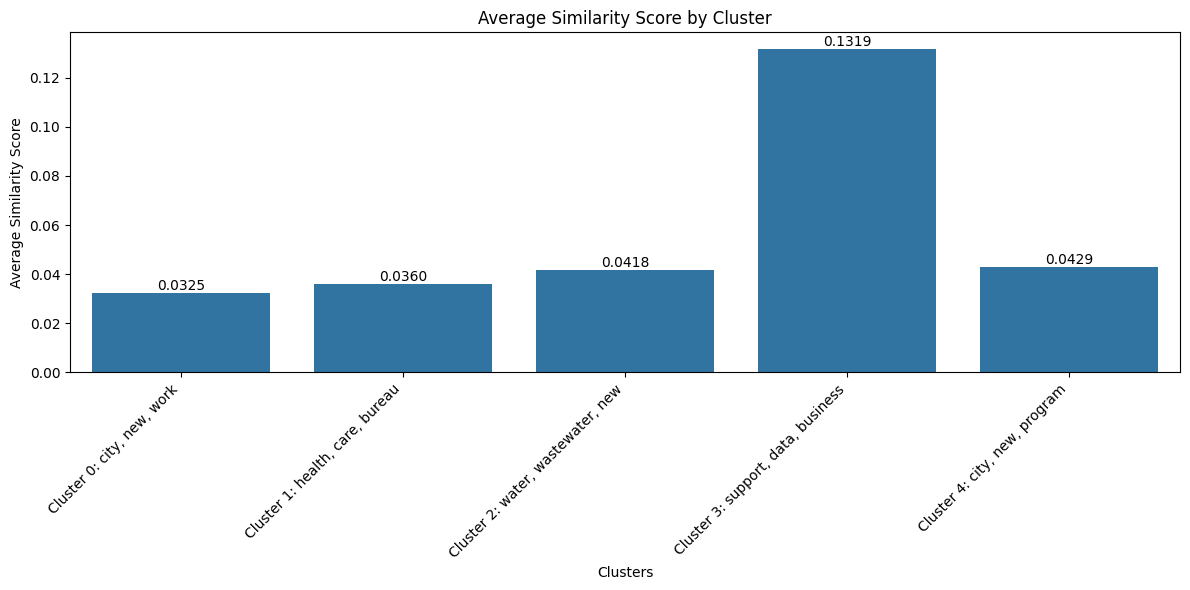

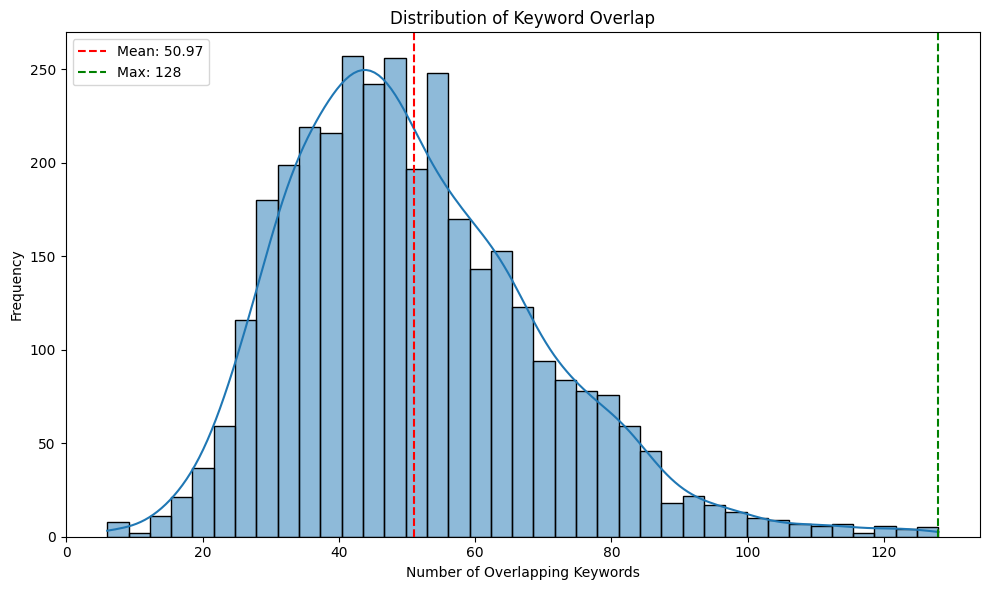

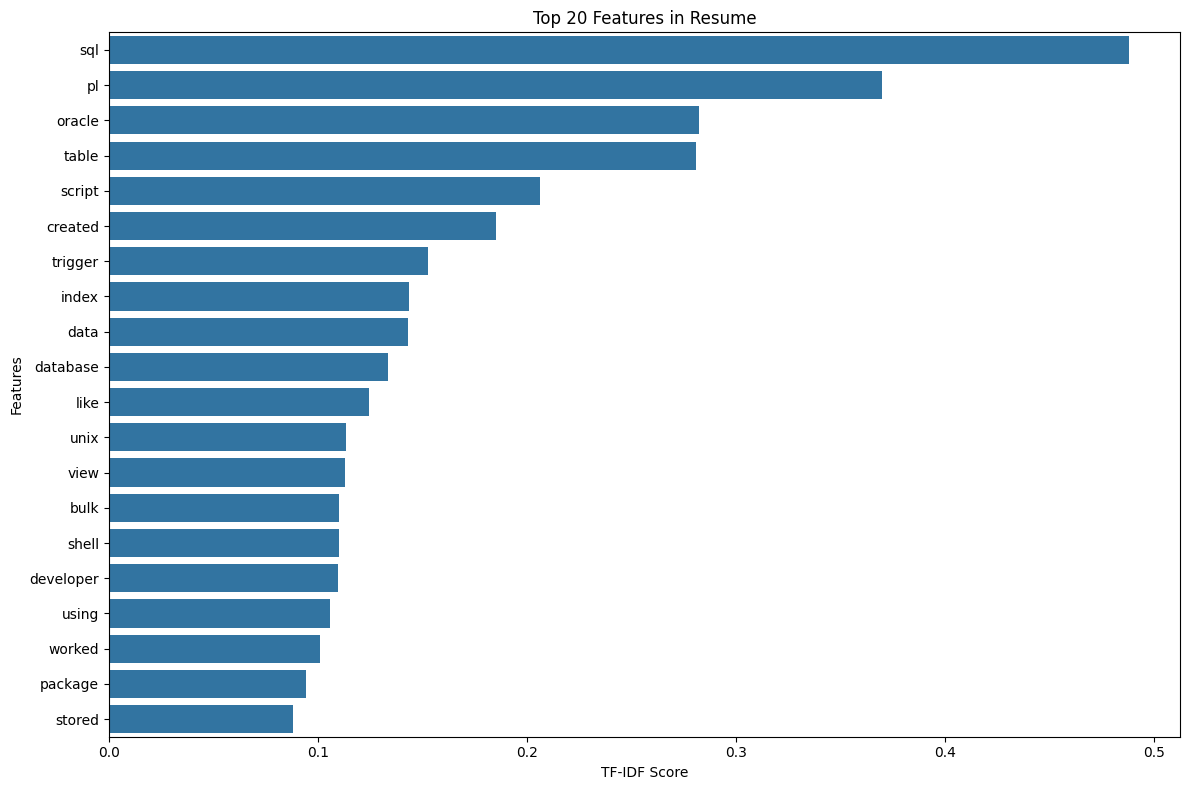

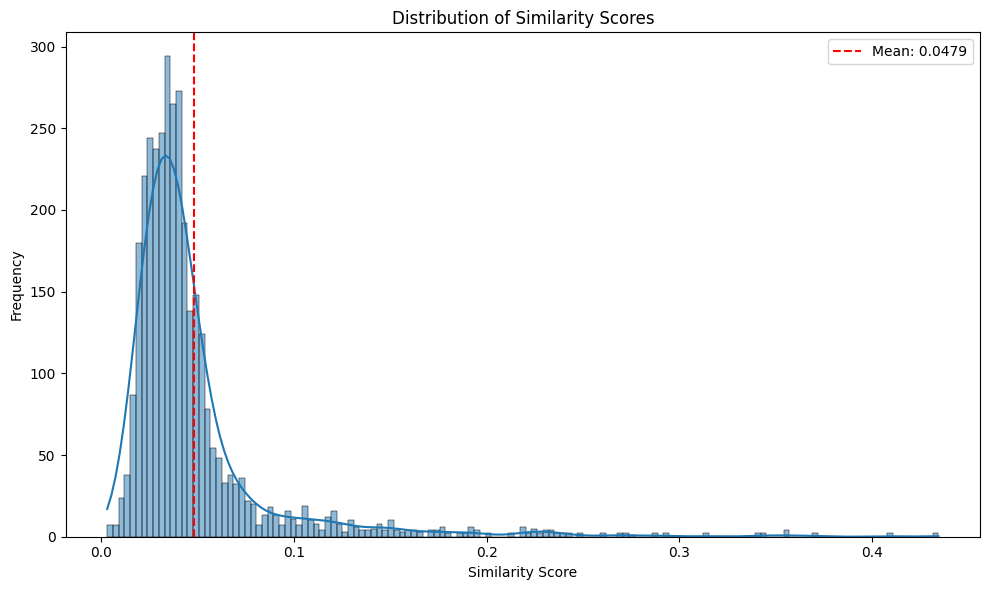

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for all plots
#plt.style.use('seaborn')

# 1. Cross-validation visualization
plt.figure(figsize=(10, 6))
plt.bar(['Training Set', 'Test Set'], [np.mean(train_similarities), np.mean(test_similarities)])
plt.title('Average Similarity Scores: Training vs Test Set')
plt.ylabel('Average Similarity Score')
plt.ylim(0, max(np.mean(train_similarities), np.mean(test_similarities)) * 1.2)
for i, v in enumerate([np.mean(train_similarities), np.mean(test_similarities)]):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 2. Clustering analysis visualization
cluster_similarities = [np.mean(similarity_scores[0][data_jobs['cluster'] == cluster]) for cluster in range(5)]
plt.figure(figsize=(12, 6))
sns.barplot(x=list(cluster_labels.values()), y=cluster_similarities)
plt.title('Average Similarity Score by Cluster')
plt.xlabel('Clusters')
plt.ylabel('Average Similarity Score')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(cluster_similarities):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 3. Keyword overlap visualization
plt.figure(figsize=(10, 6))
sns.histplot(data=data_jobs['keyword_overlap'], kde=True)
plt.title('Distribution of Keyword Overlap')
plt.xlabel('Number of Overlapping Keywords')
plt.ylabel('Frequency')
plt.axvline(data_jobs['keyword_overlap'].mean(), color='r', linestyle='--', label=f'Mean: {data_jobs["keyword_overlap"].mean():.2f}')
plt.axvline(data_jobs['keyword_overlap'].max(), color='g', linestyle='--', label=f'Max: {data_jobs["keyword_overlap"].max()}')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Feature importance visualization
plt.figure(figsize=(12, 8))
feature_scores = [score for _, score in top_features]
feature_names = [feature for feature, _ in top_features]
sns.barplot(x=feature_scores, y=feature_names)
plt.title('Top 20 Features in Resume')
plt.xlabel('TF-IDF Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
